## ML Engineering Development
In this section of the demo, we will utilize Snowpark's Python client-side Dataframe API to build and develope code for the **ML Ops pipeline**.  We will take the functions and model training/inference definition from the data scientist and put it into production using the Snowpark server-side runtime and Snowpark Python user-defined functions for ML model training and inference.

The ML Engineer will start by exploring the deoployment options and testing the deployed model before building a pipeline.

Input: Data in `trips` table.  Feature engineering, train, predict functions from data scientist.  
Output: Prediction models available to business users in SQL. Evaluation reports for monitoring.

### 1. Load  credentials and connect to Snowflake

In [1]:
from dags.snowpark_connection import snowpark_connect
session, state_dict = snowpark_connect('./include/state.json')

### 2.  Create Feature Pipelines


In [2]:
import snowflake.snowpark as snp
from snowflake.snowpark import functions as F 
from dags.feature_engineering import generate_holiday_df, generate_weather_df
from datetime import datetime

weather_listing_prefix = state_dict['weather_listing_prefix']

state_dict['trips_table_name']='TRIPS'
state_dict['holiday_table_name']='HOLIDAYS'
state_dict['weather_listing_id']= f'{weather_listing_prefix}.WEATHERSOURCE_SNOWFLAKE_SNOWPARK_TILE_SNOWFLAKE_SECURE_SHARE_1651768630709'
state_dict['weather_database_name'] = 'WEATHER'
state_dict['weather_table_name'] = state_dict['weather_database_name']+'.ONPOINT_ID.HISTORY_DAY'
state_dict['weather_view_name'] = 'WEATHER'
state_dict['model_stage_name']='MODEL_STAGE'
state_dict['run_date']='2020_01_01'

import json
with open('./include/state.json', 'w') as sdf:
    json.dump(state_dict, sdf)

We will materialize the holiday dataset as a table instead of calculating each time in the inference and training pipelines.

In [3]:
holiday_df = generate_holiday_df(session, state_dict['holiday_table_name']) 
holiday_df.write.mode('overwrite').saveAsTable(state_dict['holiday_table_name'])

Likewise we check that the weather data has been subscribed to.

In [5]:
#session.sql("CREATE OR REPLACE DATABASE "+state_dict['weather_database_name']+\
#            " FROM SHARE "+state_dict['weather_listing_id']).collect()

session.use_database(state_dict['connection_parameters']['database'])
session.use_schema(state_dict['connection_parameters']['schema'])

We will create a view in the project database referencing our specific features of that weather database.

In [6]:
weather_df = generate_weather_df(session, state_dict['weather_table_name']) 
weather_df.create_or_replace_view(state_dict['weather_view_name'])

[Row(status='View WEATHER successfully created.')]

We will need to forecast features for weather (PRECIP and TEMP) and also holidays.  For weather we could use forecast from the Snowflake Marketplace providers like Weather Source.  Since we went back in time for this hands-on-lab the weather "forecast" is actually in the historical weather tables.

In [7]:
def create_forecast_df(session, trips_table_name:str, holiday_table_name:str, weather_view_name:str, steps:int):
    from dags.feature_engineering import generate_holiday_df
    from datetime import timedelta, datetime
    from snowflake.snowpark import functions as F 
    
    start_date = session.table(trips_table_name)\
                        .select(F.to_date(F.max('STARTTIME'))).collect()[0][0]+timedelta(days=1)
    #start_date = datetime.strptime('2020-03-01', '%Y-%m-%d')
    end_date = start_date+timedelta(days=steps)

    #check if it tables already materialized, otherwise generate DF
    holiday_df = session.table(holiday_table_name)
    try: 
        _ = holiday_df.columns()
    except:
        holiday_df = generate_holiday_df(session, holiday_table_name)
        
    weather_df = session.table(weather_view_name)
        
    forecast_df = holiday_df.join(weather_df[['DATE','PRECIP','TEMP']], 'DATE', join_type='right')\
                            .na.fill({'HOLIDAY':0})\
                            .filter((F.col('DATE') >= start_date) &\
                                    (F.col('DATE') <= end_date))\
                            .sort('DATE', ascending=True)
    return forecast_df

In [8]:
forecast_steps=30
forecast_df = create_forecast_df(session=session, 
                                 trips_table_name=state_dict['trips_table_name'],
                                 holiday_table_name=state_dict['holiday_table_name'], 
                                 weather_view_name=state_dict['weather_view_name'], 
                                 steps=forecast_steps)
forecast_df.show()

----------------------------------------------
|"DATE"      |"HOLIDAY"  |"PRECIP"  |"TEMP"  |
----------------------------------------------
|2020-01-01  |1          |0.0       |-1.0    |
|2020-01-02  |0          |0.0       |2.8     |
|2020-01-03  |0          |1.2       |7.0     |
|2020-01-04  |0          |3.8       |7.3     |
|2020-01-05  |0          |0.0       |-0.8    |
|2020-01-06  |0          |0.6       |0.6     |
|2020-01-07  |0          |0.0       |2.1     |
|2020-01-08  |0          |0.0       |-3.5    |
|2020-01-09  |0          |0.0       |-5.3    |
|2020-01-10  |0          |0.0       |4.6     |
----------------------------------------------



#### Vectorized feature generation
Previously the data scientist picked one station for training and predictions.  We want to generate features for all stations in parallel.  We can leverage the power of the Snowflake SQL execution engine for this and Snowpark allows us to write it in python.  

Snowflake [window functions](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/_autosummary/snowflake.snowpark.html#snowflake.snowpark.Window) are a powerful tool for vectorizing work.  Our initial feature engineering code from the data scientist used window functions to calculate the lag features.

We can create multi-level window functions to partition by station_id and then group by date within that window.  
  
Also we will create a second window in order to make sure that each station of our features have at least 2 years worth of data (needed for the model to pickup seasonality) and has activity up to the latest date of the current dataset (to build forecast).

In [9]:
%%time
sid_date_window = snp.Window.partition_by(F.col('STATION_ID')).order_by(F.col('DATE').asc())
sid_window = snp.Window.partition_by(F.col('STATION_ID'))
latest_date = session.table(state_dict['trips_table_name']).select(F.to_char(F.to_date(F.max('STARTTIME')))).collect()[0][0]

historical_df = session.table(state_dict['trips_table_name'])\
                       .select(F.to_date(F.col('STARTTIME')).alias('DATE'),
                               F.col('START_STATION_ID').alias('STATION_ID'))\
                       .group_by(F.col('STATION_ID'), F.col('DATE'))\
                            .count()\
                       .with_column('LAG_1', F.lag(F.col('COUNT'), offset=1).over(sid_date_window))\
                       .with_column('LAG_7', F.lag(F.col('COUNT'), offset=7).over(sid_date_window))\
                       .with_column('LAG_90', F.lag(F.col('COUNT'), offset=90).over(sid_date_window))\
                       .with_column('LAG_365', F.lag(F.col('COUNT'), offset=365).over(sid_date_window))\
                            .na.drop()\
                       .join(holiday_df, 'DATE', join_type='left').na.fill({'HOLIDAY':0})\
                       .join(weather_df[['DATE','PRECIP','TEMP']], 'DATE', 'inner')\
                       .with_column('DAY_COUNT', F.count(F.col('DATE')).over(sid_window))\
                            .filter(F.col('DAY_COUNT') >= 365*2)\
                       .with_column('MAX_DATE', F.max('DATE').over(sid_window))\
                            .filter(F.col('MAX_DATE') == latest_date)

CPU times: user 64.1 ms, sys: 369 µs, total: 64.5 ms
Wall time: 1.71 s


Make sure all stations have data up to the latest date.

In [10]:
historical_df.group_by('STATION_ID').max('DATE').select(F.min(F.col('MAX(DATE)'))).show()

------------------------
|"MIN(""MAX(DATE)"")"  |
------------------------
|2019-12-31            |
------------------------



Our feature set should not include any stations with less than 730 days (365*2) of data.

In [11]:
historical_df.select(F.min('DAY_COUNT')).collect()[0][0]

730

We'll drop the day count and max date columns since we don't really need them beyond verification.

In [12]:
historical_df = historical_df.drop(['DAY_COUNT', 'MAX_DATE'])

Now how many stations have at least two years of data with recent activity?

In [13]:
historical_df.select('STATION_ID').distinct().count()

516

### 3. Create UDF for Training and Inference

Since this is a time series prediction we will retrain a model each time we do inference.  We don't need to save the model artefacts but we will save the predictions in an predictions table.  
  
Here we can use Snowpark User Defined Functions for training as well as inference without having to pull data out of Snowflake.

In [14]:
%%writefile dags/station_train_predict.py
def station_train_predict_func(historical_data:list, 
                               historical_column_names:list, 
                               target_column:str,
                               cutpoint: int, 
                               max_epochs: int, 
                               forecast_data:list,
                               forecast_column_names:list,
                               lag_values:list):
    
    from torch import tensor
    import pandas as pd
    from pytorch_tabnet.tab_model import TabNetRegressor
    from datetime import timedelta
    import numpy as np
    
    feature_columns = historical_column_names.copy()
    feature_columns.remove('DATE')
    feature_columns.remove(target_column)
    forecast_steps = len(forecast_data)
    
    df = pd.DataFrame(historical_data, columns = historical_column_names)
    
    ##In order to do train/valid split on time-based portion the input data must be sorted by date    
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.sort_values(by='DATE', ascending=True)
    
    y_valid = df[target_column][-cutpoint:].values.reshape(-1, 1)
    X_valid = df[feature_columns][-cutpoint:].values
    y_train = df[target_column][:-cutpoint].values.reshape(-1, 1)
    X_train = df[feature_columns][:-cutpoint].values
    
    model = TabNetRegressor()

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        max_epochs=max_epochs,
        patience=100,
        batch_size=128, 
        virtual_batch_size=64,
        num_workers=0,
        drop_last=True)
    
    df['PRED'] = model.predict(tensor(df[feature_columns].values))

    #Now make the multi-step forecast
    if len(lag_values) > 0:
        forecast_df = pd.DataFrame(forecast_data, columns = forecast_column_names)
        
        for step in range(forecast_steps):
            #station_id = df.iloc[-1]['STATION_ID']
            future_date = df.iloc[-1]['DATE']+timedelta(days=1)
            lags=[df.shift(lag-1).iloc[-1]['COUNT'] for lag in lag_values]
            forecast=forecast_df.loc[forecast_df['DATE']==future_date.strftime('%Y-%m-%d')]
            forecast=forecast.drop(labels='DATE', axis=1).values.tolist()[0]
            features=[*lags, *forecast]
            pred=round(model.predict(np.array([features]))[0][0])
            row=[future_date, pred, *features, pred]
            df.loc[len(df)]=row
    
    explain_df = pd.DataFrame(model.explain(df[feature_columns].astype(float).values)[0], 
                         columns = feature_columns).add_prefix('EXPL_').round(2)
    df = pd.concat([df.set_index('DATE').reset_index(), explain_df], axis=1)
    df['DATE'] = df['DATE'].dt.strftime('%Y-%m-%d')

    return [df[:-forecast_steps].to_json(orient='records', lines=False), 
            df[-forecast_steps:].to_json(orient='records', lines=False)]

Overwriting dags/station_train_predict.py


The Snowpark server-side Anaconda runtime has a large [list of Python modules included](https://docs.snowflake.com/en/LIMITEDACCESS/udf-python-packages.html#list-of-the-third-party-packages-from-anaconda) for our UDF.  However, the data scientist built this code based on pytorch-tabnet which is not currently in the Snowpark distribution.
  
  We can simply add [pytorch_tabnet](https://github.com/dreamquark-ai/tabnet), as well as our own team's python code, as import dependencies.

In [15]:
from dags.station_train_predict import station_train_predict_func
from snowflake.snowpark import types as T
import os 

#We can add dependencies from locally installed directories
#source_dir = os.environ['CONDA_PREFIX']+'/lib/python3.8/site-packages/'

_ = session.sql('CREATE STAGE IF NOT EXISTS '+state_dict['model_stage_name']).collect()

session.clear_packages()
session.clear_imports()
dep_packages=["pandas==1.3.5", "pytorch==1.10.2", "scipy==1.7.1", "scikit-learn==1.0.2", "setuptools==58.0.4", "cloudpickle==2.0.0"]
dep_imports=['./include/pytorch_tabnet.zip', 'dags']

station_train_predict_udf = session.udf.register(station_train_predict_func, 
                                                 name="station_train_predict_udf",
                                                 is_permanent=True,
                                                 stage_location='@'+state_dict['model_stage_name'], 
                                                 imports=dep_imports,
                                                 packages=dep_packages,
                                                 input_types=[T.ArrayType(), 
                                                              T.ArrayType(), 
                                                              T.StringType(), 
                                                              T.IntegerType(), 
                                                              T.IntegerType(), 
                                                              T.ArrayType(), 
                                                              T.ArrayType(), 
                                                              T.ArrayType()],
                                                 return_type=T.VariantType(),
                                                 replace=True)

#### Vectorize the training and inference

Because we currently only have scalar functions for Snowpark Python UDFs we must aggregate the features for each station to a single cell.   This will be much easier in the future with vectorized input and user-defined table functions.

In [16]:
historical_column_list = historical_df.columns
historical_column_list.remove('STATION_ID')
historical_column_names = F.array_construct(*[F.lit(x) for x in historical_column_list])

historical_df = historical_df.group_by(F.col('STATION_ID'))\
                             .agg(F.array_agg(F.array_construct(*historical_column_list))\
                                  .alias('HISTORICAL_DATA'))

forecast_column_list = forecast_df.columns
forecast_column_names = F.array_construct(*[F.lit(x) for x in forecast_column_list])
forecast_df = forecast_df.select(F.array_agg(F.array_construct(F.col('*'))).alias('FORECAST_DATA'))

### 4. Test the training/inference pipeline and prediction output.

With the array-stuffed dataframes we can now call the UDF for training, predictions and forecasting.  We will write the predictions to a table in variant (JSON) format.

In [17]:
session.use_warehouse(state_dict['compute_parameters']['train_warehouse'])

In [18]:
%%time
cutpoint=365
max_epochs = 10
target_column = 'COUNT'
lag_values=[1,7,90,365]
lag_values_array = F.array_construct(*[F.lit(x) for x in lag_values])

historical_df.join(forecast_df)\
             .select(F.col('STATION_ID'),
                     F.call_udf('station_train_predict_udf', 
                                F.col('HISTORICAL_DATA'),
                                F.lit(historical_column_names), 
                                F.lit(target_column),
                                F.lit(cutpoint), 
                                F.lit(max_epochs),
                                F.col('FORECAST_DATA'),
                                F.lit(forecast_column_names),
                                F.lit(lag_values_array)).alias('PRED_DATA'))\
           .write.mode('overwrite')\
           .save_as_table('PRED_test')

CPU times: user 20.8 ms, sys: 510 µs, total: 21.3 ms
Wall time: 42.6 s


Lets check how the model performs for some stations.

In [19]:
import pandas as pd

pred_df=session.table('PRED_test').filter(F.col('STATION_ID') == '519')\
                .select('STATION_ID', F.parse_json(F.col('PRED_DATA')[0]).alias('PRED_DATA'))\

output_json=pred_df.select('PRED_DATA').collect()

df = pd.read_json(output_json[0]['PRED_DATA'])
df.tail()

,COUNT,DATE,EXPL_HOLIDAY,EXPL_LAG_1,EXPL_LAG_365,EXPL_LAG_7,EXPL_LAG_90,EXPL_PRECIP,EXPL_TEMP,HOLIDAY,LAG_1,LAG_365,LAG_7,LAG_90,PRECIP,PRED,TEMP
2023,249,2019-12-27,0.00,0.00,66.19,49.57,0.00,0.00,47.24,0,228,295,309,258,0.0,444.925964,8.7
2024,99,2019-12-28,0.00,5.98,0.00,9.41,3.79,5.87,0.00,0,249,94,101,255,0.0,71.056236,6.5
2025,53,2019-12-29,1.39,3.74,0.00,3.91,40.91,3.31,0.00,0,99,104,88,725,2.7,149.703979,3.4
2026,93,2019-12-30,3.17,3.67,0.00,17.29,0.00,16.23,33.04,0,53,71,382,789,5.2,203.889755,0.7
2027,184,2019-12-31,0.00,3.11,0.00,22.67,39.03,4.66,0.00,0,93,100,175,671,0.4,195.106293,2.4


In [20]:
def plot(df, x_lab:str, y_true_lab:str, y_pred_lab:str):
    plt.figure(figsize=(15, 8))
    df = pd.melt(df, id_vars=[x_lab], value_vars=[y_true_lab, y_pred_lab])
    ax = sns.lineplot(x=x_lab, y='value', hue='variable', data=df)

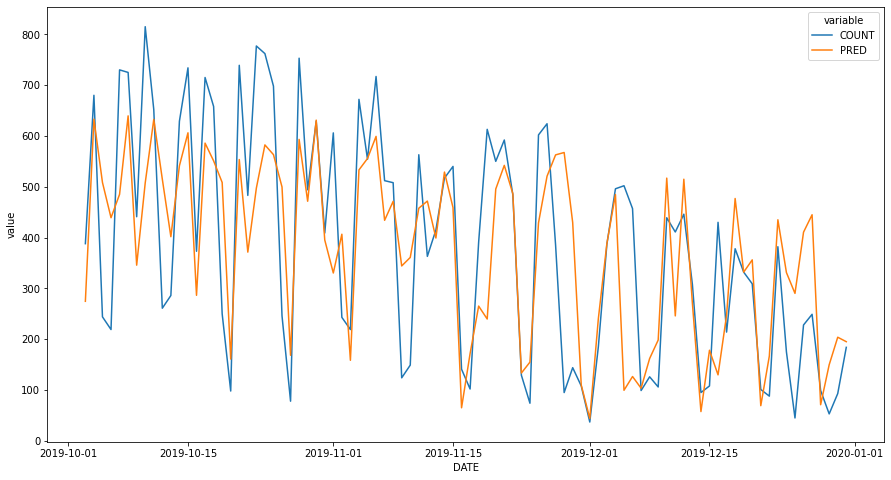

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
   
plot(df[-90:], 'DATE', 'COUNT', 'PRED')

## 5. Model Evaluation
For ML governance we need to monitor model performance over time. We will be building 100's of models (one per station) so as part of the pipeline we will add a step to evaluate model performance and save metrics for each training/inference run.

Since the data science teams may use many different model frameworks, we want to have a standard evaluation framework instead of using the model's built-in evaluation which may different for each framework or version. 

We will use [rexmex](https://rexmex.readthedocs.io/en/latest/index.html) for consistent evaluation rather than the models' built-in eval metrics. 

We will deploy the evaluation functions to the Snowpark Python server-side runtime as a Stored Procedure. We will save the model performance metrics in tables for historical analysis and drift detection as well as full reproducibility to support the company's GDPR policies.


In [22]:
from rexmex import RatingMetricSet, ScoreCard

metric_set = RatingMetricSet()
score_card = ScoreCard(metric_set)

pred_df = session.table('PRED_test')\
                 .select('STATION_ID', F.parse_json(F.col('PRED_DATA')[0]).alias('PRED_DATA'))

output_df=pd.DataFrame()
for row in pred_df.to_local_iterator():
    eval_df = pd.read_json(row.as_dict()['PRED_DATA'])
    eval_df = eval_df.rename(columns={'COUNT': 'y_true', 'PRED':'y_score'})
    eval_df = score_card.generate_report(eval_df) #.reset_index()
    eval_df['STATION_ID'] = row.as_dict()['STATION_ID']
    output_df = pd.concat([output_df, eval_df.drop('pearson_correlation', axis=1)])

session.create_dataframe(output_df).write.mode('overwrite').save_as_table('EVAL_test')

### We can create a Snowpark Python UDF to evaluate performance for all models in parallel.

In [23]:
%%writefile dags/model_eval.py
def eval_model_func(input_data: str, 
                    y_true_name: str, 
                    y_score_name: str):
    import pandas as pd
    from rexmex import RatingMetricSet, ScoreCard
        
    metric_set = RatingMetricSet()
    score_card = ScoreCard(metric_set)

    df = pd.read_json(input_data)
    df.rename(columns={y_true_name: 'y_true', y_score_name:'y_score'}, inplace=True)
    
    df = score_card.generate_report(df).reset_index()
    
    return df.to_json(orient='records', lines=False)

Overwriting dags/model_eval.py


Deploying the UDF to Snowflake makes it available for all users.  This is a regression evaluation.  Likely we will want to deploy a categorical function as well or add if/then logic to our single instance.

In [24]:
from dags.model_eval import eval_model_func
from snowflake.snowpark import types as T

model_stage_name = state_dict['model_stage_name']
_ = session.sql('CREATE STAGE IF NOT EXISTS '+model_stage_name).collect()

session.clear_packages()
session.clear_imports()
dep_packages=["pandas==1.3.5", "scikit-learn==1.0.2", "cloudpickle==2.0.0"]
dep_imports=['./include/rexmex.zip', 'dags']

eval_model_output_udf = session.udf.register(eval_model_func, 
                                             name="eval_model_output_udf",
                                             is_permanent=True,
                                             stage_location='@'+str(model_stage_name), 
                                             imports=dep_imports,
                                             packages=dep_packages,
                                             input_types=[T.StringType(), 
                                                          T.StringType(), 
                                                          T.StringType()],
                                             return_type=T.VariantType(),
                                             replace=True)

In [25]:
%%time
y_true_name='COUNT'
y_score_name='PRED'
run_date = datetime.strptime(state_dict['run_date'], '%Y_%m_%d').date()

session.table('PRED_test')\
       .select('STATION_ID',
               F.call_udf('eval_model_output_udf',
                          F.parse_json(F.col('PRED_DATA')[0]),
                          F.lit(y_true_name),
                          F.lit(y_score_name)).alias('EVAL_DATA'))\
       .with_column('RUN_DATE', F.to_date(F.lit(run_date)))\
       .write.mode('overwrite')\
       .save_as_table('EVAL_test')

CPU times: user 10.7 ms, sys: 0 ns, total: 10.7 ms
Wall time: 10.9 s


In [26]:
eval_df = session.table('EVAL_TEST')
eval_df.show()

----------------------------------------------------------------------------------
|"STATION_ID"  |"EVAL_DATA"                                         |"RUN_DATE"  |
----------------------------------------------------------------------------------
|3326          |"[{\"index\":0,\"mae\":6.4747239741,\"mse\":69....  |2020-01-01  |
|325           |"[{\"index\":0,\"mae\":25.0438412955,\"mse\":96...  |2020-01-01  |
|3429          |"[{\"index\":0,\"mae\":31.8216363135,\"mse\":17...  |2020-01-01  |
|3374          |"[{\"index\":0,\"mae\":34.8028392044,\"mse\":24...  |2020-01-01  |
|2005          |"[{\"index\":0,\"mae\":2.201171879,\"mse\":8.03...  |2020-01-01  |
|388           |"[{\"index\":0,\"mae\":41.9510154514,\"mse\":29...  |2020-01-01  |
|490           |"[{\"index\":0,\"mae\":64.7519126095,\"mse\":66...  |2020-01-01  |
|168           |"[{\"index\":0,\"mae\":42.8073214169,\"mse\":31...  |2020-01-01  |
|302           |"[{\"index\":0,\"mae\":14.193129384,\"mse\":299...  |2020-01-01  |
|398

Alternatively we could use a Stored Procedure.  This gives us lots of flexibility but will be slower for parallel execution.

In [27]:
model_stage_name = state_dict['model_stage_name']
_ = session.sql('CREATE STAGE IF NOT EXISTS '+model_stage_name).collect()

session.file.put('./include/rexmex.zip', model_stage_name)

sql_cmd = '''
CREATE OR REPLACE PROCEDURE EVAL_MODEL_SPROC(pred_table STRING, 
                                             y_true_name STRING, 
                                             y_score_name STRING,
                                             eval_table STRING)
RETURNS STRING
LANGUAGE PYTHON
RUNTIME_VERSION = '3.8'
PACKAGES = ('snowflake-snowpark-python', 'pandas==1.3.5', 'scikit-learn')
IMPORTS = ('@model_stage/rexmex.zip')
HANDLER = 'eval_model_func'
AS
$$
def eval_model_func(session, 
                    pred_table:str, 
                    y_true_name:str, 
                    y_score_name:str,
                    eval_table:str):
    from snowflake.snowpark import functions as F
    import pandas as pd
    from rexmex import RatingMetricSet, ScoreCard

    metric_set = RatingMetricSet()
    score_card = ScoreCard(metric_set)

    pred_df = session.table(pred_table)\
                     .select('STATION_ID', F.parse_json(F.col('PRED_DATA')[0]).alias('PRED_DATA'))
    output_df=pd.DataFrame()
    for row in pred_df.to_local_iterator():
        eval_df = pd.read_json(row.as_dict()['PRED_DATA'])
        eval_df = eval_df.rename(columns={y_true_name: 'y_true', y_score_name:'y_score'})
        eval_df = score_card.generate_report(eval_df)
        eval_df['STATION_ID'] = row.as_dict()['STATION_ID']
        output_df = pd.concat([output_df, eval_df.drop('pearson_correlation', axis=1)])

    session.create_dataframe(output_df).write.mode('overwrite').save_as_table('EVAL_test')

    return "SUCCESS"
$$
'''

#session.sql(sql_cmd).collect()
#session.sql("CALL EVAL_MODEL_SPROC(\'PRED_test\', \'COUNT\', \'PRED\', \'EVAL_test\')").collect()

### Finally we will create flattened versions of the PRED, FORECAST and EVAL tables by parsing the variant (JSON) columns.

In [28]:
pred_table_name='PRED_test'
forecast_table_name='FORECAST_test'
eval_table_name='EVAL_test'
session.table(pred_table_name)\
       .select('STATION_ID', F.parse_json(F.col('PRED_DATA')[0]).alias('PRED_DATA'))\
       .flatten('PRED_DATA').select('STATION_ID', F.col('VALUE').alias('PRED_DATA'))\
       .select('STATION_ID', 
               F.to_date(F.col('PRED_DATA')['DATE']).alias('DATE'),
               F.as_integer(F.col('PRED_DATA')['COUNT']).alias('COUNT'),
               F.as_integer(F.col('PRED_DATA')['LAG_1']).alias('LAG_1'),
               F.as_integer(F.col('PRED_DATA')['LAG_7']).alias('LAG_7'),
               F.as_integer(F.col('PRED_DATA')['LAG_90']).alias('LAG_90'),
               F.as_integer(F.col('PRED_DATA')['LAG_365']).alias('LAG_365'),
               F.as_integer(F.col('PRED_DATA')['HOLIDAY']).alias('HOLIDAY'),
               F.as_decimal(F.col('PRED_DATA')['PRECIP']).alias('PRECIP'),
               F.as_decimal(F.col('PRED_DATA')['TEMP']).alias('TEMP'),
               F.as_decimal(F.col('PRED_DATA')['PRED']).alias('PRED'),
               F.as_decimal(F.col('PRED_DATA')['EXPL_LAG_1']).alias('EXPL_LAG_1'),
               F.as_decimal(F.col('PRED_DATA')['EXPL_LAG_7']).alias('EXPL_LAG_7'),
               F.as_decimal(F.col('PRED_DATA')['EXPL_LAG_90']).alias('EXPL_LAG_90'),
               F.as_decimal(F.col('PRED_DATA')['EXPL_LAG_365']).alias('EXPL_LAG_365'),
               F.as_decimal(F.col('PRED_DATA')['EXPL_HOLIDAY']).alias('EXPL_HOLIDAY'),
               F.as_decimal(F.col('PRED_DATA')['EXPL_PRECIP']).alias('EXPL_PRECIP'),
               F.as_decimal(F.col('PRED_DATA')['EXPL_TEMP']).alias('EXPL_TEMP'))\
       .write.mode('overwrite').save_as_table('flat_'+pred_table_name)

#forecast are in position 2 of the pred_table
session.table(pred_table_name)\
       .select('STATION_ID', F.parse_json(F.col('PRED_DATA')[1]).alias('PRED_DATA'))\
       .flatten('PRED_DATA').select('STATION_ID', F.col('VALUE').alias('PRED_DATA'))\
       .select('STATION_ID', 
               F.to_date(F.col('PRED_DATA')['DATE']).alias('DATE'),
               F.as_integer(F.col('PRED_DATA')['COUNT']).alias('COUNT'),
               F.as_integer(F.col('PRED_DATA')['LAG_1']).alias('LAG_1'),
               F.as_integer(F.col('PRED_DATA')['LAG_7']).alias('LAG_7'),
               F.as_integer(F.col('PRED_DATA')['LAG_90']).alias('LAG_90'),
               F.as_integer(F.col('PRED_DATA')['LAG_365']).alias('LAG_365'),
               F.as_integer(F.col('PRED_DATA')['HOLIDAY']).alias('HOLIDAY'),
               F.as_decimal(F.col('PRED_DATA')['PRECIP']).alias('PRECIP'),
               F.as_decimal(F.col('PRED_DATA')['TEMP']).alias('TEMP'),
               F.as_decimal(F.col('PRED_DATA')['PRED']).alias('PRED'),
               F.as_decimal(F.col('PRED_DATA')['EXPL_LAG_1']).alias('EXPL_LAG_1'),
               F.as_decimal(F.col('PRED_DATA')['EXPL_LAG_7']).alias('EXPL_LAG_7'),
               F.as_decimal(F.col('PRED_DATA')['EXPL_LAG_90']).alias('EXPL_LAG_90'),
               F.as_decimal(F.col('PRED_DATA')['EXPL_LAG_365']).alias('EXPL_LAG_365'),
               F.as_decimal(F.col('PRED_DATA')['EXPL_HOLIDAY']).alias('EXPL_HOLIDAY'),
               F.as_decimal(F.col('PRED_DATA')['EXPL_PRECIP']).alias('EXPL_PRECIP'),
               F.as_decimal(F.col('PRED_DATA')['EXPL_TEMP']).alias('EXPL_TEMP'))\
       .write.mode('overwrite').save_as_table('flat_'+forecast_table_name)

session.table(eval_table_name)\
           .select('RUN_DATE', 'STATION_ID', F.parse_json(F.col('EVAL_DATA')).alias('EVAL_DATA'))\
           .flatten('EVAL_DATA').select('RUN_DATE', 'STATION_ID', F.col('VALUE').alias('EVAL_DATA'))\
           .select('RUN_DATE', 'STATION_ID', 
                   F.as_decimal(F.col('EVAL_DATA')['mae'], 10, 2).alias('mae'),
                   F.as_decimal(F.col('EVAL_DATA')['mape'], 10, 2).alias('mape'),
                   F.as_decimal(F.col('EVAL_DATA')['mse'], 10, 2).alias('mse'),
                   F.as_decimal(F.col('EVAL_DATA')['r_squared'], 10, 2).alias('r_squared'),
                   F.as_decimal(F.col('EVAL_DATA')['rmse'], 10, 2).alias('rmse'),
                   F.as_decimal(F.col('EVAL_DATA')['smape'], 10, 2).alias('smape'),)\
           .write.mode('append').save_as_table('flat_EVAL')

We will end by consolidating the functions we created.

In [29]:
%%writefile dags/mlops_pipeline.py

def materialize_holiday_table(session, holiday_table_name:str) -> str:
    from dags.feature_engineering import generate_holiday_df
    
    holiday_df = generate_holiday_df(session=session, holiday_table_name=holiday_table_name)
    holiday_df.write.mode('overwrite').saveAsTable(holiday_table_name)
    
    return holiday_table_name

def subscribe_to_weather_data(session, 
                              weather_database_name:str, 
                              weather_listing_id:str) -> str:
    
    session.sql("CREATE DATABASE IF NOT EXISTS "+weather_database_name+\
                " FROM SHARE "+weather_listing_id).collect()
    
    return weather_database_name

def create_weather_view(session, weather_table_name:str, weather_view_name:str) -> str:
    from dags.feature_engineering import generate_weather_df

    weather_df = generate_weather_df(session=session, weather_table_name=weather_table_name)
    
    weather_df.create_or_replace_view(weather_view_name)
    
    return weather_view_name

def deploy_pred_train_udf(session, udf_name:str, function_name:str, model_stage_name:str) -> str:
    from dags.station_train_predict import station_train_predict_func
    from snowflake.snowpark import types as T

    session.clear_packages()
    session.clear_imports()
    dep_packages=["pandas==1.3.5", "pytorch==1.10.2", "scipy==1.7.1", "scikit-learn==1.0.2", "setuptools==58.0.4", "cloudpickle==2.0.0"]
    dep_imports=['./include/pytorch_tabnet.zip', 'dags']

    station_train_predict_udf = session.udf.register(station_train_predict_func, 
                                                     name=udf_name,
                                                     is_permanent=True,
                                                     stage_location='@'+str(model_stage_name), 
                                                     imports=dep_imports,
                                                     packages=dep_packages,
                                                     input_types=[T.ArrayType(), 
                                                                  T.ArrayType(), 
                                                                  T.StringType(), 
                                                                  T.IntegerType(), 
                                                                  T.IntegerType(), 
                                                                  T.ArrayType(), 
                                                                  T.ArrayType(), 
                                                                  T.ArrayType()],
                                                     return_type=T.VariantType(),
                                                     replace=True)
    return station_train_predict_udf.name


def deploy_eval_udf(session, udf_name:str, function_name:str, model_stage_name:str) -> str:
    from dags.model_eval import eval_model_func
    from snowflake.snowpark import types as T

    session.clear_packages()
    session.clear_imports()
    dep_packages=['pandas==1.3.5', 'scikit-learn==1.0.2', "cloudpickle==2.0.0"]
    dep_imports=['./include/rexmex.zip', 'dags']

    eval_model_output_udf = session.udf.register(eval_model_func, 
                                                 name=udf_name,
                                                 is_permanent=True,
                                                 stage_location='@'+str(model_stage_name), 
                                                 imports=dep_imports,
                                                 packages=dep_packages,
                                                 input_types=[T.StringType(), 
                                                              T.StringType(), 
                                                              T.StringType()],
                                                 return_type=T.VariantType(),
                                                 replace=True)
    return eval_model_output_udf.name

def create_forecast_table(session, 
                          trips_table_name:str,
                          holiday_table_name:str, 
                          weather_view_name:str, 
                          forecast_table_name:str,
                          steps:int):
    
    from dags.feature_engineering import generate_holiday_df
    from datetime import timedelta, datetime
    from snowflake.snowpark import functions as F 
    
    start_date = session.table(trips_table_name)\
                        .select(F.to_date(F.max('STARTTIME'))).collect()[0][0]+timedelta(days=1)
    end_date = start_date+timedelta(days=steps)

    #check if it tables already materialized, otherwise generate DF
    holiday_df = session.table(holiday_table_name)
    try: 
        _ = holiday_df.columns
    except:
        holiday_df = generate_holiday_df(session, holiday_table_name)
        
    weather_df = session.table(weather_view_name)
        
    forecast_df = holiday_df.join(weather_df[['DATE','PRECIP','TEMP']], 'DATE', join_type='right')\
                            .na.fill({'HOLIDAY':0})\
                            .filter((F.col('DATE') >= start_date) &\
                                    (F.col('DATE') <= end_date))\
                            .sort('DATE', ascending=True)
    
    forecast_df.write.mode('overwrite').save_as_table(forecast_table_name)
    
    return forecast_table_name


def create_feature_table(session, 
                         trips_table_name:str, 
                         holiday_table_name:str, 
                         weather_view_name:str,
                         feature_table_name:str) -> list:

    import snowflake.snowpark as snp
    from snowflake.snowpark import functions as F 
    from dags.feature_engineering import generate_holiday_df, generate_weather_df
    
    #check if it tables already materialized, otherwise generate DF
    holiday_df = session.table(holiday_table_name)
    try: 
        _ = holiday_df.columns
    except:
        holiday_df = generate_holiday_df(session, holiday_table_name)
        
    weather_df = session.table(weather_view_name)
    
    sid_date_window = snp.Window.partition_by(F.col('STATION_ID')).order_by(F.col('DATE').asc())
    sid_window = snp.Window.partition_by(F.col('STATION_ID'))
    latest_date = session.table(trips_table_name).select(F.to_char(F.to_date(F.max('STARTTIME')))).collect()[0][0]
    
    feature_df = session.table(trips_table_name)\
                        .select(F.to_date(F.col('STARTTIME')).alias('DATE'),
                                F.col('START_STATION_ID').alias('STATION_ID'))\
                        .group_by(F.col('STATION_ID'), F.col('DATE'))\
                                .count()\
                        .with_column('LAG_1', F.lag(F.col('COUNT'), offset=1).over(sid_date_window))\
                        .with_column('LAG_7', F.lag(F.col('COUNT'), offset=7).over(sid_date_window))\
                        .with_column('LAG_90', F.lag(F.col('COUNT'), offset=90).over(sid_date_window))\
                        .with_column('LAG_365', F.lag(F.col('COUNT'), offset=365).over(sid_date_window))\
                            .na.drop()\
                        .join(holiday_df, 'DATE', join_type='left').na.fill({'HOLIDAY':0})\
                        .join(weather_df[['DATE','PRECIP','TEMP']], 'DATE', 'inner')\
                        .with_column('DAY_COUNT', F.count(F.col('DATE')).over(sid_window))\
                            .filter(F.col('DAY_COUNT') >= 365*2)\
                        .with_column('MAX_DATE', F.max('DATE').over(sid_window))\
                            .filter(F.col('MAX_DATE') == latest_date)\
                        .drop(['DAY_COUNT', 'MAX_DATE'])
    
    feature_df.write.mode('overwrite').save_as_table(feature_table_name)
    
    return feature_table_name

def train_predict(session, 
                  station_train_pred_udf_name:str, 
                  feature_table_name:str, 
                  forecast_table_name:str,
                  pred_table_name:str) -> list:
    
    from snowflake.snowpark import functions as F
    
    cutpoint=365
    max_epochs = 10
    target_column = 'COUNT'
    lag_values=[1,7,90,365]
    lag_values_array = F.array_construct(*[F.lit(x) for x in lag_values])
    
    historical_df = session.table(feature_table_name)
    historical_column_list = historical_df.columns
    historical_column_list.remove('STATION_ID')
    historical_column_names = F.array_construct(*[F.lit(x) for x in historical_column_list])

    historical_df = historical_df.group_by(F.col('STATION_ID'))\
                                 .agg(F.array_agg(F.array_construct(*historical_column_list))\
                                      .alias('HISTORICAL_DATA'))

    forecast_df = session.table(forecast_table_name)
    forecast_column_names = F.array_construct(*[F.lit(x) for x in forecast_df.columns])
    forecast_df = forecast_df.select(F.array_agg(F.array_construct(F.col('*'))).alias('FORECAST_DATA'))

    pred_df = historical_df.join(forecast_df)\
                           .select(F.col('STATION_ID'),
                         F.call_udf(station_train_pred_udf_name, 
                                    F.col('HISTORICAL_DATA'),
                                    F.lit(historical_column_names), 
                                    F.lit(target_column),
                                    F.lit(cutpoint), 
                                    F.lit(max_epochs),
                                    F.col('FORECAST_DATA'),
                                    F.lit(forecast_column_names),
                                    F.lit(lag_values_array)).alias('PRED_DATA'))\
                 .write.mode('overwrite')\
                 .save_as_table(pred_table_name)

    return pred_table_name

def evaluate_station_model(session, 
                           run_date:str, 
                           eval_model_udf_name:str, 
                           pred_table_name:str, 
                           eval_table_name:str):
    from snowflake.snowpark import functions as F
    from datetime import datetime
    
    y_true_name='COUNT'
    y_score_name='PRED'
    run_date=datetime.strptime(run_date, '%Y_%m_%d').date()

    session.table(pred_table_name)\
           .select('STATION_ID',
                   F.call_udf(eval_model_udf_name,
                              F.parse_json(F.col('PRED_DATA')[0]),
                              F.lit(y_true_name),
                              F.lit(y_score_name)).alias('EVAL_DATA'))\
           .with_column('RUN_DATE', F.to_date(F.lit(run_date)))\
           .write.mode('overwrite')\
           .save_as_table(eval_table_name)
    
    return eval_table_name

def flatten_tables(session, pred_table_name:str, forecast_table_name:str, eval_table_name:str):
    from snowflake.snowpark import functions as F
    
    session.table(pred_table_name)\
           .select('STATION_ID', F.parse_json(F.col('PRED_DATA')[0]).alias('PRED_DATA'))\
           .flatten('PRED_DATA').select('STATION_ID', F.col('VALUE').alias('PRED_DATA'))\
           .select('STATION_ID', 
                   F.to_date(F.col('PRED_DATA')['DATE']).alias('DATE'),
                   F.as_integer(F.col('PRED_DATA')['COUNT']).alias('COUNT'),
                   F.as_integer(F.col('PRED_DATA')['LAG_1']).alias('LAG_1'),
                   F.as_integer(F.col('PRED_DATA')['LAG_7']).alias('LAG_7'),
                   F.as_integer(F.col('PRED_DATA')['LAG_90']).alias('LAG_90'),
                   F.as_integer(F.col('PRED_DATA')['LAG_365']).alias('LAG_365'),
                   F.as_integer(F.col('PRED_DATA')['HOLIDAY']).alias('HOLIDAY'),
                   F.as_decimal(F.col('PRED_DATA')['PRECIP']).alias('PRECIP'),
                   F.as_decimal(F.col('PRED_DATA')['TEMP']).alias('TEMP'),
                   F.as_decimal(F.col('PRED_DATA')['PRED']).alias('PRED'),
                   F.as_decimal(F.col('PRED_DATA')['EXPL_LAG_1']).alias('EXPL_LAG_1'),
                   F.as_decimal(F.col('PRED_DATA')['EXPL_LAG_7']).alias('EXPL_LAG_7'),
                   F.as_decimal(F.col('PRED_DATA')['EXPL_LAG_90']).alias('EXPL_LAG_90'),
                   F.as_decimal(F.col('PRED_DATA')['EXPL_LAG_365']).alias('EXPL_LAG_365'),
                   F.as_decimal(F.col('PRED_DATA')['EXPL_HOLIDAY']).alias('EXPL_HOLIDAY'),
                   F.as_decimal(F.col('PRED_DATA')['EXPL_PRECIP']).alias('EXPL_PRECIP'),
                   F.as_decimal(F.col('PRED_DATA')['EXPL_TEMP']).alias('EXPL_TEMP'))\
           .write.mode('overwrite').save_as_table('flat_PRED')

    #forecast are in position 2 of the pred_table
    session.table(pred_table_name)\
           .select('STATION_ID', F.parse_json(F.col('PRED_DATA')[1]).alias('PRED_DATA'))\
           .flatten('PRED_DATA').select('STATION_ID', F.col('VALUE').alias('PRED_DATA'))\
           .select('STATION_ID', 
                   F.to_date(F.col('PRED_DATA')['DATE']).alias('DATE'),
                   F.as_integer(F.col('PRED_DATA')['COUNT']).alias('COUNT'),
                   F.as_integer(F.col('PRED_DATA')['LAG_1']).alias('LAG_1'),
                   F.as_integer(F.col('PRED_DATA')['LAG_7']).alias('LAG_7'),
                   F.as_integer(F.col('PRED_DATA')['LAG_90']).alias('LAG_90'),
                   F.as_integer(F.col('PRED_DATA')['LAG_365']).alias('LAG_365'),
                   F.as_integer(F.col('PRED_DATA')['HOLIDAY']).alias('HOLIDAY'),
                   F.as_decimal(F.col('PRED_DATA')['PRECIP']).alias('PRECIP'),
                   F.as_decimal(F.col('PRED_DATA')['TEMP']).alias('TEMP'),
                   F.as_decimal(F.col('PRED_DATA')['PRED']).alias('PRED'),
                   F.as_decimal(F.col('PRED_DATA')['EXPL_LAG_1']).alias('EXPL_LAG_1'),
                   F.as_decimal(F.col('PRED_DATA')['EXPL_LAG_7']).alias('EXPL_LAG_7'),
                   F.as_decimal(F.col('PRED_DATA')['EXPL_LAG_90']).alias('EXPL_LAG_90'),
                   F.as_decimal(F.col('PRED_DATA')['EXPL_LAG_365']).alias('EXPL_LAG_365'),
                   F.as_decimal(F.col('PRED_DATA')['EXPL_HOLIDAY']).alias('EXPL_HOLIDAY'),
                   F.as_decimal(F.col('PRED_DATA')['EXPL_PRECIP']).alias('EXPL_PRECIP'),
                   F.as_decimal(F.col('PRED_DATA')['EXPL_TEMP']).alias('EXPL_TEMP'))\
           .write.mode('overwrite').save_as_table('flat_FORECAST')

    session.table(eval_table_name)\
           .select('RUN_DATE', 'STATION_ID', F.parse_json(F.col('EVAL_DATA')).alias('EVAL_DATA'))\
           .flatten('EVAL_DATA').select('RUN_DATE', 'STATION_ID', F.col('VALUE').alias('EVAL_DATA'))\
           .select('RUN_DATE', 'STATION_ID', 
                   F.as_decimal(F.col('EVAL_DATA')['mae'], 10, 2).alias('mae'),
                   F.as_decimal(F.col('EVAL_DATA')['mape'], 10, 2).alias('mape'),
                   F.as_decimal(F.col('EVAL_DATA')['mse'], 10, 2).alias('mse'),
                   F.as_decimal(F.col('EVAL_DATA')['r_squared'], 10, 2).alias('r_squared'),
                   F.as_decimal(F.col('EVAL_DATA')['rmse'], 10, 2).alias('rmse'),
                   F.as_decimal(F.col('EVAL_DATA')['smape'], 10, 2).alias('smape'),)\
           .write.mode('append').save_as_table('flat_EVAL')
    
    return 'flat_PRED', 'flat_FORECAST', 'flat_EVAL'
        

Overwriting dags/mlops_pipeline.py


In [30]:
session.close()